# RL homework 1
**Due date: Friday 7 February 2020, 11am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: ***Agnieszka Dobrowolska***

Student number: ***16034489***

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 and 2
* Lecture slides

**Overview of this assignment**

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [0]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
      for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [0]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
      for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [0]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `name` and an argument `number_of_arms`. It might (optionally) have agent specific args.

## Example agent

The following code block contains an example random agent.

In [0]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[10 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [0]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name
    self.c = bonus_multiplier
    self.reset()

  def step(self, previous_action, reward):
    '''Returns an action between 0 and 'number of arms by' which maximises the UCB '''
    
    #1.  Update the state
    if previous_action is not None:
      self.Nt[previous_action] += 1
      self.Q[previous_action] += 1/self.Nt[previous_action]*(reward - self.Q[previous_action])

    # 2. Pick action
    # Check if N_t(a) = 0 for any of the actions
    if 0 in self.Nt:
      # Get indices of actions that have N_t(a) = 0
      indxs = np.argwhere(self.Nt==0)
      # Select a random one of these
      action = indxs[np.random.randint(len(indxs))][0]

    else:
      # Pick action that max'es UCB 
      values = self.Q + self.c * np.sqrt(1/self.Nt * np.log(self.t))
      # Get indices of identical maxima
      ind_max = np.where(values == np.max(values))
      # Break ties randomly (uniformly)
      action = ind_max[np.random.randint(len(ind_max))][0]

    # Update t
    self.t +=1    

    return action

  def reset(self):
    self.Nt = np.zeros(self._number_of_arms)
    self.Q = np.zeros(self._number_of_arms)
    self.t = 0

## Q2
**[10 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to have a time-changing $\epsilon$ schedule. In
particular, your agent should be able to decay its $\epsilon$ parameter as
a polynomial over time, e.g., $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$.
Your agent should also be able to output a constant $\epsilon$, e.g.,
$\epsilon_t=0.1\,,\forall t$.

If multiple actions have the same value, ties should be broken randomly.

The exploration should be defined in the constructor by feeding in addition arguments in place of the `...` below.

In [0]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, nu=None, const_epsilon=None):
    self.name = name
    self._number_of_arms = number_of_arms
    self.nu = nu
    self.const_epsilon = const_epsilon
    self.reset()
    

  def step(self, previous_action, reward):
    
    if previous_action is None:
      action = np.random.randint(self._number_of_arms)
    
    else:
      # 1. Update state
      self.Nt[previous_action] += 1
      self.Q[previous_action] += 1/self.Nt[previous_action]*(reward - self.Q[previous_action])

      # 2. Pick action
      if np.random.random() <= self.epsilon:
        # Pick randomly
        action = np.random.randint(self._number_of_arms)
      else:
        # Pick action which maximises Q, choosing randomly amongst multiple maxima
        # Get indices of maxima
        ind_max = np.argwhere(self.Q == np.max(self.Q))
        # Pick randomly amongst them 
        action = ind_max[np.random.randint(len(ind_max))][0]

    # Update time step
    self.t += 1

    # Update epsilon
    if self.nu is not None:
      self.epsilon = self.t**(-self.nu)

    return action

  def reset(self):
    self.Nt = np.zeros(self._number_of_arms)
    self.Q = np.zeros(self._number_of_arms)
    self.t = 0
    if self.nu is not None:
      self.epsilon = 0 # we can initialise to 0 since on the first step we pick randomly at t = 0
    else:
      self.epsilon = self.const_epsilon

## Q3
**[10 pts]** Implement a softmax REINFORCE agent.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [0]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline = True):
    self._number_of_arms = number_of_arms
    self.name = name
    self.alpha = step_size
    self.baseline = baseline
    self.reset()

  def step(self, previous_action, reward):
    
    if previous_action is None:
      action = np.random.randint(self._number_of_arms)
    
    else:
      
      # 1.1 Update baseline: mean of all rewards for all actions
      if self.baseline == True:
        self.mean_rewards += 1/self.t * (reward - self.mean_rewards)
        
      # 1.2 Update preference for previous_action
      self.Ht[previous_action] += self.alpha * (reward - self.mean_rewards) * (1 - self.pi[previous_action])

      # 1.3 Update preference for all other actions
      mask = np.ones(self._number_of_arms, dtype=bool)
      mask[previous_action] = False
      self.Ht[mask] -= self.alpha * (reward - self.mean_rewards) * self.pi[mask]

      # 1.4 Compute action probabilities
      self.pi = np.exp(self.Ht)/np.sum(np.exp(self.Ht))

      # 2. Pick action 
      action = np.random.choice(np.arange(self._number_of_arms), p=self.pi)
    
    self.t += 1

    return action

  def reset(self):
    self.Ht = np.zeros(self._number_of_arms)
    self.pi = np.zeros(self._number_of_arms)
    self.t = 0
    self.mean_rewards = 0


## Q4

**[10 pts]** Implement an agent that selects actions according to Thompson sampling for Bernoulli bandits.

The agent assumes the bandit arms have a bernoulli distribution, and starts with a uniform Beta prior on each action.  Because this prior fully defines the algorithm, the agent does not need to take addition arguments in the constructor.  The algorithm shoud ignore any rewards that are not zero or one.

In [0]:
class Thompson(object):

  def __init__(self, name, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    
    if previous_action is None:
      action = np.random.randint(self._number_of_arms)
    
    else:

      # Update the parameters
      if reward == 1:
        self.alphas[previous_action] += 1
      elif reward ==0:
        self.betas[previous_action] += 1

      thetas = []
      # Draw a sample from each distribution
      for i in range(self._number_of_arms):
        thetas.append(np.random.beta(self.alphas[i], self.betas[i]))
      
      # Pick action
      action = np.argmax(thetas)
 
    return action

  def reset(self):
    self.alphas = np.ones(self._number_of_arms)
    self.betas = np.ones(self._number_of_arms)
  

# Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [0]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        const_epsilon = 0),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        const_epsilon = 0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        nu = 1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        nu = 0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms, 0.25, baseline = False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        0.25, baseline = True),
    Thompson(
        "Thompson",
        number_of_arms),
]

train_agents(agents, number_of_arms, number_of_steps)

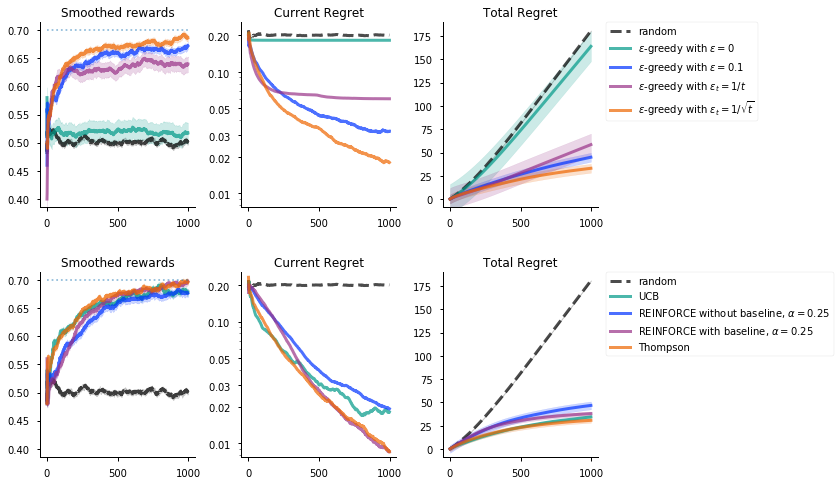

In [0]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best three algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

We find that the best three algorithms for the given problem are Thompson Sampling, UCB and REINFORCE with baseline.

- **Thompson Sampling**: We would expect Thompson Sampling to perform well in general since it utilises a sophisticated exploration schedule, selecting optimal action conditioned on history. It **satifies the Lai and Robbins lower bound on regret, which makes it optimal.**

- **UCB**: UCB should perform well in general as it implements guided exploration, selecting amongst non-greedy actions according to their potential to be greedy since it considers both, the q-values and the uncertainty in their estimates. 
While it does not achieve the Lai & Robbins lower bound on regret, it is **guaranteed to achieve logarithmic total regret loss.** It should perform well in stationary problems as exploration decreases with time. Moreover, since we are using 1/N as the coefficient to incrementally compute the q-values, the q-values are guaranteed to converge for stationary problems according to the law of large numbers. In non-stationary problems UCB may struggle to adapt if a change occurs at a high time-step since it's rate of exploration will be small. 

- **REINFORCE with baseline**: We expect reinforce to perform well since it **achieves asymptotic logarithmic expected total regret**, which guarantees convergence, though it might be slow,  and the use of a baseline makes it **unbiased**. However, the choice of the baseline will affect the variance of the update and thus influence the rate of convergence.


**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.


Across smooth rewards, current regret and total regret we observe that the ordering of the ranking is constant, with $\epsilon = 1/\sqrt{1}$ performing the best and the fully greedy agent performing worst. 

- $\mathbf{\epsilon = 0}$: The fully greedy agent at the very beginning achieved greater rewards than the other 3 agents, but it's performance quickly drops and it performs only slightly better than a random agent. This is because this agent always picks deterministically the action $a$ which has the highest estimated action value associated with it. Hence, it **does not attempt to trade-off exploration and exploitation**, sacreficing all exploration for short-term gain. As it does not explore, it's value function estimates for the non-greedy actions it is not selecting are inaccurate and the agent is stuck performing sub-optimal actions.

- $\mathbf{\epsilon = 1/t}$: The agent with $\epsilon=1/t$ performs better, as it now **performs some exploration** and will pick a random action with small probability $\epsilon$. This improves it's action values estimates for the non-greedy actions and hence increases it's chances of finding the optimum action. However, here $\epsilon$ decays quickly as a function of t, hence the agent quickly stops exploring and becomes almost fully greedy. As the decay 1/t is too quick, the exploration time is cut short and the optimal actions are not found.


- $\mathbf{\epsilon = 0.1}$:  The constant $\epsilon$ on the other hand **continues to explore independently of t** and long-term achieves higher rewards since it is able to find the optimum actions. However, as in this case we are in the stationary setting, the **continuous exploration means that the q-values will not converge** as it doesn't becomes increasing greedy but contiues to explore indefinately.


- $\mathbf{\epsilon = 1/\sqrt{t}}$: We find that $\epsilon = 1/\sqrt{t}$ performs best. This is because it manages to **best balance exploration with exploitation** in this setting: it explores sufficiently to find the optimum actions as introducing the square-root term makes the decay of $\epsilon$ slower. On the other hand, the decay is fast enough so that the agent eventually stops exploring and starts to maximise rewards and thus minimise regret.


## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [0]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

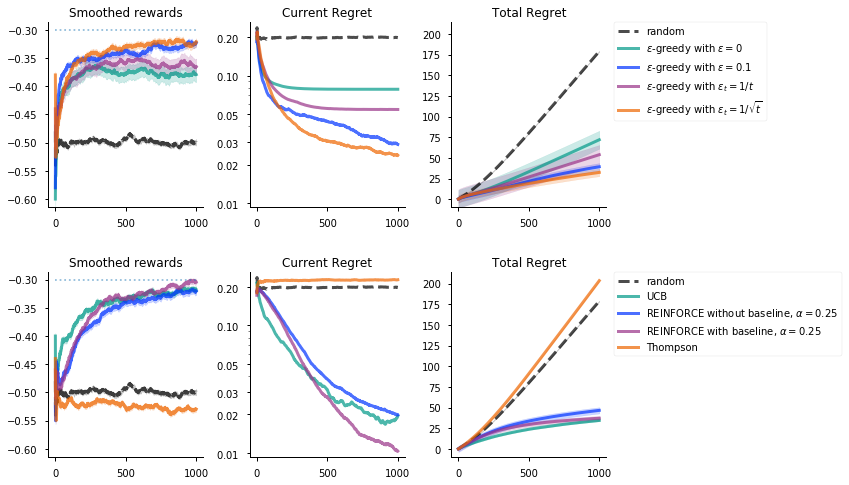

In [0]:
experiment2.show()

## Q6
**[10pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.


- **$\epsilon$-greedy with $\epsilon = 0 $**: The performance of the model decidedly improves - we can assume this is due to the optimistic initalisation. Here we initialise all values to 0, which also happens to be the reward on success - hence we introduce a bias: it can be thought of as supplying additional knowledge to the model about the level of reward it should expect. As here we only update our q-values on *failure* this means the agent is more biased towards all the non-selected actions, as opposed to developing a bias towards the few actions that deliver a reward, as it does in experiment 1 - as a result, the model in experiment 2 explores more, obtains better estimates of action values and hence is more likely to find the optimal actions.

- **$\epsilon$-greedy with $\epsilon = 0.1 $**: We observe very little change here. This is because the effect of optimistic initalisation is marginal in comparison with the influence of having a constant probability of $\epsilon$ which ensures sufficient exploration at every time step.

- **$\epsilon$-greedy with $\epsilon = 1/t$**: We notice some improvement here: slightly higher smoothed rewards and the current regret is lower by about 0.01. As this agent is quite similar to the fully-greedy agent and fails to find optimum actions due to insufficient exploration, additional exploration at the beginning as a result of the optimistic initalisation improves the q-value estimates of the non-greedy actions.

- **$\epsilon$-greedy with $\epsilon = 1/\sqrt{t}$**: Once again, we observe very little change here, for the same reasons as for  $\epsilon = 0.1 $. We also notice that here it took the agent longer to maximise it's rewards than in experiment 1, due to the additional exploration in the initial phase.

- **UCB**: We do not observe any significant changes here. This is because exploration in UCB is guided by a balance between how many times an action has been selected, the time step and the q-value estimates - hence the change in value of the rewards does not affect the $U_t$ term, and the $Q_t(a)$ term is reduced for every action. Therefore, shifting the values of the rewards down has no effect on the way UCB chooses actions.

- **REINFORCE with no baseline**: Here we no longer initialise and compute q-values, but iteratively compute preferences $H_t(a)$ instead. In experiment 2 a success does not alter the preferences, but a failure causes the preference for one of the actions to decrease and the preference for all the other actions to increase. This makes them more likely to be sampled in future iterations, hence leading to more exploration and ultimately increasing the chances of optimal actions being found and exploited in the long-term. 

- **REINFORCE with baseline**: We do not find significant changes here - this is because the reward is considered relative to the average, and since both the indivual reward and average reward are both shifted, we are effectively just scaling the function and this does not impact the way the algorithm chooses actions. 

- **Thompson Sampling**: The performance of Thompson dractically drops, to the extent where this agent performs worse than a random agent. This is because this agent now only updates it's distribution for rewards of 0, hence it only updates its $\beta$ parameter, which results in the distribution being radically inaccurate, hence the samples from every distribution are also biased and thus it performs worse than a random agent.

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [0]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        const_epsilon = 0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        nu = 0.5),
    UCB('ucb',
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r'REINFORCE with a baseline, $\alpha=0.25$',
        number_of_arms, 0.25, baseline = True),
]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [0]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

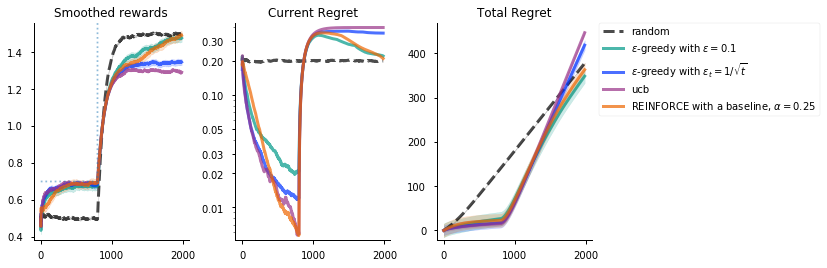

In [0]:
experiment3.show()

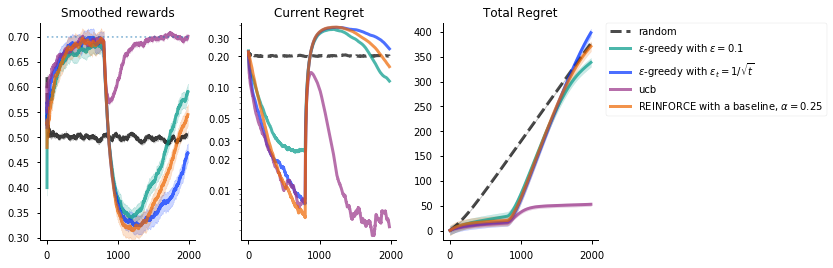

In [0]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[10 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.


After the rewards change, the performance of UCB drops from best to worst, and $\epsilon = 1/\sqrt{t}$ now ranks second-last - this is because the exploration for both of these algorithms decays with time, hence by t=800 they are both acting mostly greedily, rarely updating their estimates for the non-greedy actions. As the reward for the greedy actions does not change, they do not detect the change in the distribution of the 'failure' rewards and get stuck performing actions that are not optimal. Reinforce with baseline performs significantly better and ranks second-best, since the sampling ensures that the agent keeps exploring: as the reward for failure increases from +1 to +2 and the policy values will be large for both successfull and failure arms, this is reflected in the samples and thus the algorithm adapts faster than UCB and finds the optimum actions much faster. We observe that  $\epsilon = 0.1$ performs best since it keeps exploring independent of t, thus as it will detect the change in reward distribution, exploration will further increase the as q-values change and thus the agent will discover the new optimum actions.
 


**[10 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.


In this scenario the reward for the success changes, which means that the q-values for the greedy actions change, as do the preferences in the case of Reinforce - as the greedy actions no longer perform as expected, all algorithms end up exploring more - this leads to a decrease in current regret that is much steeper for all of the algorithms in experiment 4 than it is for experiment 3. We find that the $\epsilon$ -greedy with $\epsilon$ =1/$\sqrt{t}$ performs worst as it takes longest to adapt - this is because the $\epsilon$ -values are decaying with time, which results in little exploration at high t. In 3rd and 2nd place are Reinforce and $\epsilon$-greedy with $\epsilon = 0.1$ respectively - Reinforce explores more as it's preferences change as a result of the new reward distribution and $\epsilon$ = 0.1 keeps exploring independently of t - those both of them eventually find the new optimum actions, though the q-values for $\epsilon$ -greedy will not converge. The change in Reinforcement with baseline is slower than one would expect since it is a Monte Carlo method and these are known for slow learning due to their estimates having large variance as result of sampling. Best performance is achieved by UCB which quickly adapts and significantly outperforms the other algorithms - this is because it is the most sensitive to the change in q-values and hence the fastest to start exploring the alternative arms, and find the new optimal actions. 




**[5 pts]** Explain how and why the current-regret curve for UCB in 
**experiment 3** differs from the curve in **experiment 4**.

After first 800 steps the value of the $U_t$ term is very small for both of the agents as each of the actions has been selected a large number of times, hence the agent is doing very little exploration and is acting mostly greedily. Thus, the difference in perfomance must be due to a change in the Q-term.
In experiment 3, if the agent continues to choose the actions which once were optimal, the Q-values of these actions will not change, since the reward (+1) is the same, thus there is no reason for the agent to explore - hence UCB does not realise the non-stationarity and it gets stuck performing the non-optimal actions. Meanwhile in experiment 4, the old 'success' actions no longer deliver the expected reward, which results in the Q-values changing - this causes the agent to start exploring more and hence discover the new optimal actions.

**[5 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

In a non-stationary problem we wish to give greater importance to the more recent rewards as opposed to giving all rewards equal weighting. This could be achieved by modifying the way in which we incrementally compute the average reward to make it a weighted average of past rewards and the initial estimate $Q_1$ (Sutton & Barto, 2018). We refomulate the update rule to give:

$$Q_{n+1} = Q_n + \alpha[R_n - Q_n]$$

where we introduce the parameter $\alpha$, where $\alpha \in (0,1]$ is a constant. The effect $\alpha$ has is more clearly seen when we expand and reformulate the above equation to give us:

$$Q_{n+1} = (1-\alpha)^n Q_1+ \sum^{n}_{i=1} \alpha (1-\alpha)^{n-1} R_i$$

Hence, as the time-step increases, the weight given to observations in the past decays exponentially. The optimum choice of $\alpha$ will depend on the nature of the given problem and hence can be found by hyperparameter tunning.


**[10 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

The standard formulation of UCB is not well-suited to non-stationary problems since it's exploration decreases with increased time-step t. We can model the rewards $X_s(i)$, where $s \geq 1$ for the $\text{i}^{th}$ arm as a sequence of independent random variables, which come from (potentially) different distributions that could vary with time-step, $t$.

- One way to adapt UCB to a non-stationary problem is to introduce adaptive exploration. The agent needs to be sensitive to the changes in the rewards distribution and to increase it's exploration when it detects a change. This can be achieved by making the parameter $c$ a variable which depends on the difference between the recent rewards for action $A_t$ and the average value for the action, such that $ c = |Q_t(a) - R_t(a)|$ Hence, as the magnitude of the difference increases, the exploration increases. If we wanted to further fine-tune this, we could introduce a constant scaling factor in front of the modulus. 

- Alternatively, we can also modify the way that we compute the $Q_t(a)$ value, such that it gives greater importance to the recent rewards. This can be achieved in two ways -  in a 'soft' way, as  Koczis and Szepesvari (2006) do, through introducing a constant of $\gamma \in (0,1)$ to weight more the rewards for the the recent examples. In this case selecting optimum $\gamma$ will require hyperparameter tunning. 

- A more abrupt computation of the $Q_t(a)$ value was suggested by Garivier and Moulines in (2008) in a "sliding-window" UCB scheme: averaging the rewards for only the $\tau$ recent observations, thus computing a local average. 